# Multimodal Speech Enhancement

This notebook trains **HeavyFusionUNet**, an audio-visual model that denoises speech by fusing **log-Mel spectrogram** patches (80×94) with short **video frame** sequences (12×RGB at 112×112). It works on **CUDA**, **Apple MPS**, or **CPU**, using the GRID corpus organized per speaker.

## What this notebook does
- Sets device, seeds, and DataLoader workers.
- Builds **GridMultimodalDataset** reading:
  - `audio_noisy_mel/{train,val,test}/*.npy`
  - `audio_mel/{train,val,test}/*.npy`
  - `videos/{train,val,test}/*.(mpg|mp4)`  
  (aligned by basename)
- Defines `UNet` (audio), `DeepVideoCNN` (video), and **HeavyFusionUNet** (mid-level fusion with residual prediction).
- Trains with **Charbonnier + MSE**, **AdamW**, **ReduceLROnPlateau**, gradient clipping, and AMP on CUDA.
- Saves checkpoints every 5 epochs and **`best_model.pth`** on validation improvement.
- Plots training/validation loss curves.

## Expected data layout
Root: `DATA_DIR = ../../data/dataset` (excluding `s21`)

## Defaults
- Epochs: `EPOCH = 40` (early stopping enabled)
- Batch size: 16
- Mel: 80×94 | Frames: 12 @ 112×112
- Checkpoints dir: `MDL_PTH = ../../data/model`

## How to use
1. Run cells top-to-bottom; sanity checks print tensor shapes.
2. To resume, keep `best_model.pth` (and the latest `checkpoint_epoch_*.pth`) in `MDL_PTH`.
3. To restart from scratch, delete those files or toggle the `RESET_*` flags.

In [ ]:
# imports
import os, subprocess, shutil, random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm

try:
    import google.colab  # type: ignore
    ON_COLAB = True
except ImportError:
    ON_COLAB = False

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print("Using device:", DEVICE)
if DEVICE.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
elif DEVICE.type == 'mps':
    try:
        mp.set_start_method("spawn", force=True)
    except RuntimeError:
        pass
    os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["OPENCV_FFMPEG_LOGLEVEL"] = "quiet"
cv2.setNumThreads(4)

if ON_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    SRC_DIR  = Path("/content/drive/MyDrive/multimodal-data")
    MDL_PTH  = Path("/content/drive/MyDrive/multimodal-ckpt")
    DATA_DIR = Path("/content/data")
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    if not (DATA_DIR / ".copied").exists():
        subprocess.run(["rsync","-a","--info=progress2", f"{SRC_DIR}/", f"{DATA_DIR}/"], check=True)
        (DATA_DIR / ".copied").touch()
else:
    DATA_DIR = Path("../../data/dataset")
    MDL_PTH  = Path("../../data/model")

MDL_PTH.mkdir(parents=True, exist_ok=True)

EPOCH     = 40
B_V_LOSS  = float('inf')

if DEVICE.type == 'cuda' or ON_COLAB:
    NUM_WORKERS   = 4
    PIN_MEMORY    = True
    PREFETCH_FACT = 4
else:
    NUM_WORKERS   = 0
    PIN_MEMORY    = False
    PREFETCH_FACT = None

print(f"DATA_DIR: {DATA_DIR}")
print(f"MDL_PTH : {MDL_PTH}")
print(f"NUM_WORKERS={NUM_WORKERS}, PIN_MEMORY={PIN_MEMORY}, PREFETCH={PREFETCH_FACT}")

Using device: mps
DATA_DIR: ../../data/dataset
MDL_PTH : ../../data/model
NUM_WORKERS=0, PIN_MEMORY=False, PREFETCH=None


## GridMultimodalDataset

Loads **paired audio–visual samples** from a single GRID subject folder (e.g., `s1_processed`) and returns:
- **noisy Mel-spectrogram**
- **RGB (or grayscale) video frames**
- **clean Mel-spectrogram** (target)

Pairs are matched by filename **key** across modalities.

---

#### Constructor args
- `subject_dir`: path to `sX_processed`
- `split`: `'train' | 'val' | 'test'`
- `n_frames`: frames sampled per clip (default **12**)
- `frame_size`: `(W, H)` resize (default **112×112**)
- `use_cache`: save/load pre-extracted frames as `.npy`
- `grayscale`: return 1-channel frames if `True` (else RGB)

---

#### `__getitem__` outputs
1. `mel_noisy: FloatTensor` — shape **[80, T]**
2. `frames: FloatTensor` — shape **[F, C, H, W]**  
   (`F=n_frames`, `C=3` RGB or `1` gray, `(H,W)=frame_size`)
3. `mel_clean: FloatTensor` — shape **[80, T]**

> **Batching:** use `pad_collate_fn` to crop/pad Mel width to **94** → batch tensors `[B, 1, 80, 94]`.

---

#### Frame extraction & caching
- Frames are **uniformly spaced** over the video with OpenCV.
- If `use_cache=True`, frames are stored under `frames_cache/<split>/<key>.npy`.
- Missing/unreadable videos return a zero tensor with the correct shape.

---

#### Robustness
- Raises `FileNotFoundError` if no paired keys exist between `audio_noisy_mel` and `audio_mel`.
- Per-file load issues raise `RuntimeError` including the failing key.

In [ ]:
class GridMultimodalDataset(Dataset):
    def __init__(self, subject_dir, split='train', n_frames=12, frame_size=(112,112), use_cache=True, grayscale=False):
        self.audio_noisy_dir = subject_dir / 'audio_noisy_mel' / split
        self.audio_clean_dir = subject_dir / 'audio_mel' / split
        self.videos_dir      = subject_dir / 'videos' / split

        noisy_keys = {p.stem for p in self.audio_noisy_dir.glob("*.npy")}
        clean_keys = {p.stem for p in self.audio_clean_dir.glob("*.npy")}
        self.keys  = sorted(noisy_keys & clean_keys)  

        self.n_frames   = n_frames
        self.frame_size = frame_size
        self.use_cache  = use_cache
        self.grayscale  = grayscale
        self.cache_dir  = subject_dir / 'frames_cache' / split
        if self.use_cache:
            self.cache_dir.mkdir(parents=True, exist_ok=True)

        if len(self.keys) == 0:
            raise FileNotFoundError(f"No Mel pair found in {self.audio_noisy_dir} / {self.audio_clean_dir}")

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        try:
            mel_noisy = np.load(self.audio_noisy_dir / f"{key}.npy").astype(np.float32)
            mel_clean = np.load(self.audio_clean_dir / f"{key}.npy").astype(np.float32)
            mel_noisy = np.nan_to_num(mel_noisy, nan=0.0, posinf=0.0, neginf=0.0)
            mel_clean = np.nan_to_num(mel_clean, nan=0.0, posinf=0.0, neginf=0.0)
        except Exception as e:
            raise RuntimeError(f"Error loading Mel for key {key}: {e}")

        frames = self._load_frames(key)

        if frames.shape[0] != self.n_frames:
            padded = np.zeros((self.n_frames, *frames.shape[1:]), dtype=np.float32)
            n = min(self.n_frames, frames.shape[0])
            padded[:n] = frames[:n]
            frames = padded

        mel_noisy = torch.from_numpy(mel_noisy).float()
        mel_clean = torch.from_numpy(mel_clean).float()
        frames    = torch.from_numpy(frames).float()
        return mel_noisy, frames, mel_clean

    def _load_frames(self, key: str) -> np.ndarray:
        if self.use_cache:
            cache_path = self.cache_dir / f"{key}.npy"
            if cache_path.exists():
                try:
                    return np.load(cache_path)
                except Exception:
                    pass 

        vid_path_mp4 = self.videos_dir / f"{key}.mp4"
        vid_path_mpg = self.videos_dir / f"{key}.mpg"
        video_path   = str(vid_path_mp4 if vid_path_mp4.exists() else vid_path_mpg)

        cap = cv2.VideoCapture(video_path)
        if (not cap.isOpened()) or int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) == 0:
            cap.release()
            C = 1 if self.grayscale else 3
            return np.zeros((self.n_frames, C, self.frame_size[1], self.frame_size[0]), dtype=np.float32)

        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        idxs  = np.linspace(0, max(total-1, 0), self.n_frames).astype(int)

        C = 1 if self.grayscale else 3
        H, W = self.frame_size[1], self.frame_size[0]
        out  = np.zeros((self.n_frames, C, H, W), dtype=np.float32)

        for i, fidx in enumerate(idxs):
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fidx))
            ret, frame = cap.read()
            if not ret or frame is None:
                continue
            if self.grayscale:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = cv2.resize(frame, (W, H), interpolation=cv2.INTER_AREA)
                frame = frame[None, ...] / 255.0
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (W, H), interpolation=cv2.INTER_AREA)
                frame = np.transpose(frame, (2,0,1)) / 255.0
            out[i] = frame.astype(np.float32)

        cap.release()

        if self.use_cache:
            try:
                np.save(self.cache_dir / f"{key}.npy", out, allow_pickle=False)
            except Exception:
                pass
        return out

## pad_collate_fn

Collates a batch of tuples `(mel_noisy, frames, mel_clean)` into fixed-shape tensors.

- **Input (per sample)**
  - `mel_noisy`: FloatTensor **[80, T]** or **[1, 80, T]**
  - `frames`:    FloatTensor **[F, C, H, W]** (kept as is)
  - `mel_clean`: FloatTensor **[80, T]** or **[1, 80, T]**

- **Output (batched)**
  - `mel_noisy_batch`: **[B, 1, 80, 94]**
  - `frames_batch`:    **[B, F, C, H, W]**
  - `mel_clean_batch`: **[B, 1, 80, 94]**

- **How it works**
  - Unsqueezes Mel tensors to have a channel when needed.
  - Pre-allocates zero tensors and **copies/crops** the leftmost `min(T, 94)` columns.
  - This effectively **pads with zeros** on the right if `T < 94`, or **crops** if `T > 94`.
  - `frames` are copied without resizing or padding.

Use as `DataLoader(..., collate_fn=pad_collate_fn)`.

In [3]:
def pad_collate_fn(batch):
    B = len(batch)
    H, W = 80, 94

    # prealloc mels
    mel_noisy_batch = torch.zeros(B, 1, H, W, dtype=torch.float32)
    mel_clean_batch = torch.zeros(B, 1, H, W, dtype=torch.float32)

    mn0, fr0, mc0 = batch[0]
    if mn0.ndim == 2:
        mn0 = mn0.unsqueeze(0)
        mc0 = mc0.unsqueeze(0)
    F, C, FH, FW = fr0.shape
    frames_batch = torch.zeros(B, F, C, FH, FW, dtype=torch.float32)

    for i, (mn, fr, mc) in enumerate(batch):
        if mn.ndim == 2:
            mn = mn.unsqueeze(0)
            mc = mc.unsqueeze(0)
        crop_w = min(mn.shape[-1], W)
        mel_noisy_batch[i, :, :, :crop_w] = mn[:, :, :crop_w]
        mel_clean_batch[i, :, :, :crop_w] = mc[:, :, :crop_w]
        frames_batch[i] = fr

    return mel_noisy_batch, frames_batch, mel_clean_batch

## Loader + quick sanity checks

- **Dataset**: builds `GridMultimodalDataset` for `s1_processed` with split=`train`.
- **DataLoader**: `batch_size=4`, shuffling on, `collate_fn=pad_collate_fn`; uses `num_workers`, `pin_memory`, and (if workers > 0) `prefetch_factor` + `persistent_workers`.
- **Shape check**: pulls one batch and prints
  - `mel_noisy_b`: `[B, 1, 80, 94]`
  - `frames_b`   : `[B, F, C, H, W]`
  - `mel_clean_b`: `[B, 1, 80, 94]`
- **Quick viz**:
  - Shows a raw **noisy Mel-spectrogram** from `dataset[0]` with `imshow(...)`, `origin="lower"`.
  - Shows the **first RGB video frame** (H×W×3) from the same sample.

Use this cell to verify dataloader wiring, tensor shapes, and that both modalities (audio/video) decode correctly.

mel_noisy shape: torch.Size([4, 1, 80, 94])
frames shape   : torch.Size([4, 12, 3, 112, 112])
mel_clean shape: torch.Size([4, 1, 80, 94])


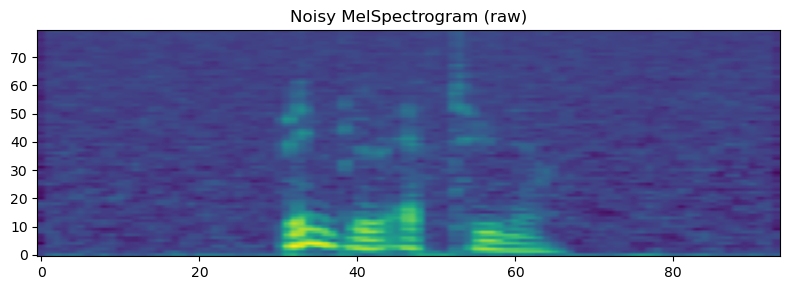

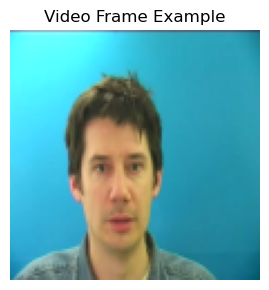

In [ ]:
subject_dir = DATA_DIR / "s1_processed"
dataset = GridMultimodalDataset(subject_dir, split='train')

loader_kwargs = dict(
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=pad_collate_fn,
)
if NUM_WORKERS > 0:
    loader_kwargs.update(dict(prefetch_factor=PREFETCH_FACT, persistent_workers=True))

loader = DataLoader(dataset, **loader_kwargs)

mel_noisy_b, frames_b, mel_clean_b = next(iter(loader))
print("mel_noisy shape:", mel_noisy_b.shape)  
print("frames shape   :", frames_b.shape)     
print("mel_clean shape:", mel_clean_b.shape)  

mel_single, frames_single, _ = dataset[0]   

plt.figure(figsize=(8,3))
plt.imshow(mel_single.numpy(), aspect='auto', origin='lower')
plt.title("Noisy MelSpectrogram (raw)")
plt.tight_layout()
plt.show()

frame0 = frames_single[0].permute(1,2,0).numpy() 
plt.figure(figsize=(3,3))
plt.imshow(frame0)
plt.title("Video Frame Example")
plt.axis('off')
plt.tight_layout()
plt.show()

## DoubleConv — brief description

`DoubleConv` is a reusable convolutional block used in the U‑Net encoder/decoder. It stacks **two** 3×3 convolutions (no bias), each followed by **GroupNorm** and **ReLU**; optional `Dropout2d` is applied after each activation when `dropout > 0`. The GroupNorm group count is chosen as the largest divisor of `out_ch` ≤ `groups`, ensuring valid grouping and stable training with small batches.

- **Signature:** `DoubleConv(in_ch: int, out_ch: int, dropout: float = 0.0, groups: int = 8)`
- **Input → Output:** `(B, in_ch, H, W) → (B, out_ch, H, W)`
- **Notes:** Spatial size is preserved by padding; removing bias is appropriate with normalization layers.

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, dropout: float = 0.0, groups: int = 8):
        super().__init__()
        g = min(groups, out_ch)
        if out_ch % g != 0:
            for gg in range(g, 0, -1):
                if out_ch % gg == 0:
                    g = gg
                    break

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(g, out_ch),
            nn.ReLU(inplace=True),
            *( [nn.Dropout2d(dropout)] if dropout > 0 else [] ),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(g, out_ch),
            nn.ReLU(inplace=True),
            *( [nn.Dropout2d(dropout)] if dropout > 0 else [] ),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)

## UNet (audio encoder–decoder)

**Overview.** A 2D UNet used on log‑Mel patches. It preserves spatial resolution while building rich features via an encoder–decoder with skip connections. The module is generic: `in_ch` is usually 1 (Mel), while `out_ch` can be 1 (map) or a feature width (e.g., 512) when used as an embedding source.

**Input / Output.** Expects a tensor **B×in_ch×H×W** and returns **B×out_ch×H×W**. Shapes are kept constant end‑to‑end; if odd sizes cause a mismatch, the forward path force‑matches with bilinear interpolation before concatenation.

**Encoder.** For each value in `features`, applies `DoubleConv(prev_ch, feat)` then `MaxPool2d(2)`, storing the pre‑pool activations as skip tensors.

**Bottleneck.** A final `DoubleConv(prev_ch, prev_ch*2)` expands channel capacity at the deepest level.

**Decoder.** Iterates over `reversed(features)`: upsamples ×2 (bilinear) and uses a 1×1 conv to reduce channels, concatenates with the corresponding skip, then applies `DoubleConv(feat*2, feat)`.

**Projection.** A 1×1 `Conv2d(prev_ch, out_ch)` produces the final map. In this project, the UNet output is often globally averaged over H×W to obtain a fixed‑length audio embedding for fusion with the video branch.

**Regularization & Norm.** Normalization and dropout live inside `DoubleConv` (GroupNorm + Dropout2d), which makes the UNet robust with small batch sizes compared to BatchNorm.

**Why this design.**
- Skip connections preserve fine‑grained time–frequency details (formants/onsets) lost by pooling.
- Bilinear upsampling + 1×1 conv is lightweight and avoids checkerboard artifacts from transposed convs.
- The explicit size check keeps concatenations safe when H/W are not powers of two.

In [6]:
class UNet(nn.Module):
    def __init__(self, in_ch: int = 1, out_ch: int = 1,
                 features: list = [32, 64, 128, 256, 512], dropout: float = 0.1):
        super().__init__()
        self.encs, self.pools = nn.ModuleList(), nn.ModuleList()
        prev_ch = in_ch
        for feat in features:
            self.encs.append(DoubleConv(prev_ch, feat, dropout=dropout))
            self.pools.append(nn.MaxPool2d(2))
            prev_ch = feat
        self.bottleneck = DoubleConv(prev_ch, prev_ch * 2, dropout=dropout)
        prev_ch *= 2
        self.ups, self.decs = nn.ModuleList(), nn.ModuleList()
        for feat in reversed(features):
            self.ups.append(nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.Conv2d(prev_ch, feat, kernel_size=1, bias=False)
            ))
            self.decs.append(DoubleConv(feat * 2, feat, dropout=dropout))
            prev_ch = feat
        self.final = nn.Conv2d(prev_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skips = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x); skips.append(x); x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.ups, self.decs, reversed(skips)):
            x = up(x)
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
            x = dec(x)
        return self.final(x)

## DeepVideoCNN — 3D visual encoder

**Purpose.** Extracts a fixed-length visual embedding from short frame sequences (lip/mouth region), to be fused with the audio branch.

**Input / Output**
- **Input** `x`: tensor shaped **[B, F, C, H, W]** with F frames per sample, RGB channels, values in [0,1].
- **Output**: tensor **[B, out_features]** (default 256‑D) — one embedding per clip.

**Architecture (sequential)**
1. `Conv3d(in_channels→base_channels, k=(3,5,5), stride=(1,2,2), pad=(1,2,2))` → GroupNorm → ReLU → Dropout3d  
2. `Conv3d(base_channels→2*base_channels, k=3, stride=(1,2,2), pad=1)` → GroupNorm → ReLU → Dropout3d  
3. `Conv3d(2*base_channels→4*base_channels, k=3, stride=1, pad=1)` → GroupNorm → ReLU  
4. `AdaptiveAvgPool3d((1,1,1))` (global spatiotemporal pooling)  
5. `Flatten → Linear(4*base_channels → out_features) → ReLU → Dropout`

**Implementation details**
- **GroupNorm** uses a dynamic group count (`groups ≤ channels`) for stability with small batches.  
- **Spatial downsampling only**: strides on H/W, the temporal axis keeps stride 1 to preserve short‑term lip dynamics.  
- **Permutation**: in `forward`, frames are reordered **[B,F,C,H,W] → [B,C,F,H,W]** before `conv3d`.

**Design rationale**
- 3D convolutions capture lip motion and coarticulation cues that are complementary to audio features.  
- Global pooling yields a **fixed‑size** descriptor regardless of F and spatial size.  
- Lightweight configuration (base_channels=32) keeps inference fast on CPU/MPS while retaining discriminative power.

**Expected preprocessing**
- Frames resized to **112×112**, RGB or grayscale by configuration, normalized to `[0,1]`.  
- Uniform sampling over the time window that aligns with the Mel patch used by the audio branch.

In [ ]:
class DeepVideoCNN(nn.Module):
    """
    3D CNN to extract fixed-length video features from frame sequences.
    """
    def __init__(self, in_channels: int = 3, base_channels: int = 32,
                 out_features: int = 256, dropout: float = 0.2, groups: int = 8):
        super().__init__()

        def GN(c):
            g = min(groups, c)
            if c % g != 0:
                for gg in range(g, 0, -1):
                    if c % gg == 0:
                        g = gg
                        break
            return nn.GroupNorm(g, c)

        self.conv3d = nn.Sequential(
            nn.Conv3d(in_channels, base_channels, kernel_size=(3,5,5), stride=(1,2,2), padding=(1,2,2), bias=False),
            GN(base_channels), nn.ReLU(inplace=True), nn.Dropout3d(dropout),

            nn.Conv3d(base_channels, base_channels*2, kernel_size=3, stride=(1,2,2), padding=1, bias=False),
            GN(base_channels*2), nn.ReLU(inplace=True), nn.Dropout3d(dropout),

            nn.Conv3d(base_channels*2, base_channels*4, kernel_size=3, stride=1, padding=1, bias=False),
            GN(base_channels*4), nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool3d((1,1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_channels*4, out_features),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0,2,1,3,4).contiguous() 
        return self.fc(self.conv3d(x))

## HeavyFusionUNet (audio–visual fusion head)

**What it does.** Merges audio UNet features and video 3D‑CNN features to predict a denoised log‑Mel patch. The head predicts a **residual** over a per‑sample **z‑scored** input and rescales back using the original mean/std. A learnable scalar **α** (`res_alpha`) controls the residual strength.

**Inputs**
- `mel_noisy`: `(B, 1, 80, 94)` float log‑Mel patch.
- `frames`: `(B, F, 3, H, W)` RGB frame stack; defaults `F=12`, `H=W=112`.

**Output**
- `(B, 80, 94)` denoised log‑Mel patch (same resolution as input, channel squeezed).

**Forward (high level)**
1. **Standardize per sample:** `μ = mean(mel)`, `σ = std(mel)+1e-5`, `mel_z = (mel_noisy − μ) / σ`.
2. **Audio path:** `a_feat = audio_unet(mel_z)` → global average over (H,W) → shape `(B, audio_feat)`.
3. **Video path:** `v_feat = video_cnn(frames)` → shape `(B, video_feat)`.
4. **Fusion MLP:** concat `[a_feat, v_feat]` → `fusion` (Linear → LayerNorm → ReLU → Dropout ×2) → `resid` with shape `(B, 80, 94)`.
5. **Residual prediction:** `pred_z = mel_z.squeeze(1) + tanh(resid) * α` (keeps updates bounded; `α` is learnable).
6. **Unstandardize:** `pred = pred_z * σ.squeeze(1) + μ.squeeze(1)`.

**Shapes & defaults**
- `audio_feat=512`, `video_feat=256`, `fusion_size=512`, `out_shape=(80,94)`, `dropout=0.3`.

**Design notes**
- Residual on normalized space stabilizes training and decouples loudness from content.
- `tanh` limits extreme corrections; `α` adapts overall correction magnitude during learning.
- Mid‑level fusion lets each branch specialize (acoustics vs. lip motion) while still interacting before decoding.
- Optional warm‑up used in training: freeze the video branch for the first epochs, then unfreeze.

In [ ]:
class HeavyFusionUNet(nn.Module):
    """
    Fuses audio UNet features and video CNN features to predict clean spectrogram.
    Uses per-sample z-score normalization and a learnable residual scale.
    """
    def __init__(self, audio_feat: int = 512, video_feat: int = 256,
                 fusion_size: int = 512, out_shape: tuple = (80,94), dropout: float = 0.3,
                 res_alpha_init: float = 5.0, audio_features: list | None = None):
        super().__init__()
        feats = audio_features if audio_features is not None else [32, 64, 128, 256, audio_feat // 2]
        self.audio_unet = UNet(in_ch=1, out_ch=audio_feat, features=feats, dropout=dropout)
        self.video_cnn  = DeepVideoCNN(in_channels=3, base_channels=32,
                                       out_features=video_feat, dropout=dropout)
        self.fusion     = nn.Sequential(
            nn.Linear(audio_feat + video_feat, fusion_size),
            nn.LayerNorm(fusion_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fusion_size, fusion_size),
            nn.LayerNorm(fusion_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fusion_size, out_shape[0] * out_shape[1])
        )
        self.out_shape = out_shape
        self.res_alpha = nn.Parameter(torch.tensor(res_alpha_init, dtype=torch.float32))

    def forward(self, mel_noisy: torch.Tensor, frames: torch.Tensor) -> torch.Tensor:
        mu  = mel_noisy.mean(dim=[2,3], keepdim=True)
        std = mel_noisy.std(dim=[2,3], keepdim=True) + 1e-5
        mel_z = (mel_noisy - mu) / std

        a_feat = self.audio_unet(mel_z).mean(dim=[2,3])  
        v_feat = self.video_cnn(frames)                  
        x = torch.cat([a_feat, v_feat], dim=1)           
        resid = self.fusion(x).view(-1, self.out_shape[0], self.out_shape[1])

        pred_z = mel_z.squeeze(1) + torch.tanh(resid) * self.res_alpha
        pred   = pred_z * std.squeeze(1) + mu.squeeze(1)
        return pred

In [9]:
def pad_collate_fn(batch):
    B = len(batch)
    H, W = 80, 94
    mel_noisy_batch = torch.zeros(B, 1, H, W, dtype=torch.float32)
    mel_clean_batch = torch.zeros(B, 1, H, W, dtype=torch.float32)

    mn0, fr0, mc0 = batch[0]
    F, C, FH, FW = fr0.shape
    frames_batch = torch.zeros(B, F, C, FH, FW, dtype=torch.float32)

    for i, (mn, fr, mc) in enumerate(batch):
        if mn.ndim == 2:
            mn = mn.unsqueeze(0)
            mc = mc.unsqueeze(0)
        w = mn.shape[-1]
        crop_w = min(w, W)
        mel_noisy_batch[i, :, :, :crop_w] = mn[:, :, :crop_w]
        mel_clean_batch[i, :, :, :crop_w] = mc[:, :, :crop_w]
        frames_batch[i] = fr

    return mel_noisy_batch, frames_batch, mel_clean_batch

In [ ]:
all_subjects = [DATA_DIR / f"s{i}_processed" for i in range(1, 35) if i != 21]
train_sets   = [GridMultimodalDataset(subj, split='train') for subj in all_subjects]
val_sets     = [GridMultimodalDataset(subj, split='val')   for subj in all_subjects]

train_set = ConcatDataset(train_sets)
val_set   = ConcatDataset(val_sets)

assert len(train_set) > 0, f"No samples in train_set. Check {DATA_DIR}/*/audio_noisy_mel/train"
assert len(val_set)   > 0, f"No samples in val_set.   Check {DATA_DIR}/*/audio_noisy_mel/val"

def make_loader(ds, batch_size, shuffle):
    """Build a DataLoader with the global NUM_WORKERS/PIN_MEMORY settings."""
    kwargs = dict(
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        collate_fn=pad_collate_fn,
    )
    if NUM_WORKERS > 0:
        kwargs.update(dict(prefetch_factor=PREFETCH_FACT, persistent_workers=True))
    return DataLoader(ds, **kwargs)

train_loader = make_loader(train_set, batch_size=16, shuffle=True)
val_loader   = make_loader(val_set,   batch_size=16, shuffle=False)

model = HeavyFusionUNet()
if DEVICE.type == 'cuda':
    try:
        model = torch.compile(model)
    except Exception:
        pass
model.to(DEVICE)

mel_noisy, frames, mel_clean = next(iter(train_loader))
print("mel_noisy shape:", mel_noisy.shape)   
print("frames shape   :", frames.shape)      
print("mel_clean shape:", mel_clean.shape)   

if mel_noisy.ndim == 3:
    mel_noisy = mel_noisy.unsqueeze(1)

model.eval()
with torch.no_grad():
    out = model(mel_noisy.to(DEVICE), frames.to(DEVICE))
print("model output shape:", out.shape)       
print(f"device used: {DEVICE}")

mel_noisy shape: torch.Size([16, 1, 80, 94])
frames shape   : torch.Size([16, 12, 3, 112, 112])
mel_clean shape: torch.Size([16, 1, 80, 94])
model output shape: torch.Size([16, 80, 94])
device used: mps


## Training objective & optimization (quick note)

- **Charbonnier loss**  
  Robust L1-like loss with smooth epsilon:  
  \( \mathcal{L}_{\text{charb}}(p,t)=\sqrt{(p-t)^2+\epsilon^2} \) (here \(\epsilon=10^{-3}\)).  
  The code auto-adds a channel dimension if inputs are 3D.

- **Composite criterion**  
  Final loss = Charbonnier + \(0.05\times\) MSE:  
  `criterion(pred, target) = crit_charb(pred, target) + 0.05 * F.mse_loss(pred, target)`  
  Balances robustness (Charbonnier) with amplitude fidelity (MSE).

- **Optimizer**  
  `AdamW(lr=3e-4, weight_decay=1e-4)` — decoupled weight decay for better generalization.

- **LR Scheduler**  
  `ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, mode='min')` — halves LR after 3 stagnant validation epochs.

- **Gradient clipping**  
  `clip_grad_norm_ = 5.0` — prevents exploding gradients and stabilizes training.


In [ ]:
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3, reduction="mean"):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, pred, target):
        if pred.ndim == 3:   pred = pred.unsqueeze(1)
        if target.ndim == 3: target = target.unsqueeze(1)
        diff = pred - target
        loss = torch.sqrt(diff * diff + self.eps * self.eps)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

crit_charb = CharbonnierLoss(eps=1e-3)

def criterion(pred, target):
    if pred.ndim == 3:   pred = pred.unsqueeze(1)
    if target.ndim == 3: target = target.unsqueeze(1)
    return crit_charb(pred, target) + 0.05 * F.mse_loss(pred, target)


optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True
)

GRAD_CLIP_NORM = 5.0

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ.setdefault("PYTHONHASHSEED", str(SEED))

RESET_CHECKPOINTS = False   
RESET_BEST        = False   

MDL_PTH.mkdir(parents=True, exist_ok=True)

removed = 0
if RESET_CHECKPOINTS:
    for p in MDL_PTH.glob("checkpoint_epoch_*.pth"):
        try:
            p.unlink(missing_ok=True)
            removed += 1
        except Exception as e:
            print(f"Warning: could not delete {p.name}: {e}")

if RESET_BEST:
    try:
        (MDL_PTH / "best_model.pth").unlink(missing_ok=True)
    except Exception as e:
        print(f"Warning: could not delete best_model.pth: {e}")

print(f"Checkpoint cleanup -> removed {removed} epoch files; best_model removed: {RESET_BEST}.")

Checkpoint cleanup -> removed 0 epoch files; best_model removed: False.


## Training loop, checkpointing, and early stopping (quick note)

- Automatically resumes if `MDL_PTH/best_model.pth` or the latest `checkpoint_epoch_*.pth` exists; otherwise starts from scratch.
- Uses `ReduceLROnPlateau` (factor 0.5, patience 3, min_lr 1e-6); the current learning rate is printed every epoch.
- For the first 5 epochs, the video branch (`model.video_cnn`) is frozen to stabilize the audio path, then it is unfrozen for joint training.
- Mixed precision is enabled on CUDA via `torch.amp.autocast` and `GradScaler`; on CPU/MPS the loop runs in FP32.
- Global gradient norm is clipped to 5.0.
- Optional hook: if a function named `spec_augment_input` is present in the namespace, it is applied to the noisy Mel inputs during training.
- After each epoch, validation loss is computed and used to step the scheduler.
- Checkpoints are saved every 5 epochs (and at the final epoch), storing epoch number, model and optimizer states, and the validation loss.
- The best model is saved to `best_model.pth` whenever validation loss improves by at least `min_delta = 1e-3`.
- Early stopping halts training after `patience = 6` epochs without validation improvement.
- Per-epoch training/validation losses are accumulated in `train_loss_l` and `val_loss_l` for later plotting.

In [ ]:
train_loss_l = []
val_loss_l   = []

start_epoch = 1
checkpoint_path = MDL_PTH / "best_model.pth"

if checkpoint_path.exists():
    print(f"Loading pre-trained model from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    last_ckpt = sorted(MDL_PTH.glob("checkpoint_epoch_*.pth"))
    if last_ckpt:
        ckpt = torch.load(last_ckpt[-1], map_location=DEVICE)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        start_epoch = ckpt['epoch'] + 1
        B_V_LOSS = ckpt['loss']
        print(f"Resuming from epoch {start_epoch} with Val Loss {B_V_LOSS:.6f}")
else:
    print("No pre-trained model found. Starting training from scratch.")

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

patience   = 6
min_delta  = 1e-3
bad_epochs = 0
best_val   = B_V_LOSS

use_amp = (DEVICE.type == 'cuda')
scaler  = torch.amp.GradScaler(enabled=use_amp)

def current_lr(opt):
    return opt.param_groups[0]['lr']

for epoch in range(start_epoch, EPOCH + 1):
    if epoch <= 5:
        for p in model.video_cnn.parameters(): p.requires_grad = False
    else:
        for p in model.video_cnn.parameters(): p.requires_grad = True

    model.train()
    train_loss = 0.0

    for mel_noisy, frames, mel_clean in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCH} [Train using: {DEVICE}]"):
        if 'spec_augment_input' in globals():
            mel_noisy = spec_augment_input(mel_noisy.clone())

        mel_noisy, frames, mel_clean = mel_noisy.to(DEVICE), frames.to(DEVICE), mel_clean.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast():
                outputs = model(mel_noisy, frames)
                loss = criterion(outputs, mel_clean)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(mel_noisy, frames)
            loss = criterion(outputs, mel_clean)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()

        train_loss += loss.item() * mel_noisy.size(0)

    train_loss /= len(train_loader.dataset)
    train_loss_l.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_noisy, frames, mel_clean in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCH} [Val]"):
            mel_noisy, frames, mel_clean = mel_noisy.to(DEVICE), frames.to(DEVICE), mel_clean.to(DEVICE)
            outputs = model(mel_noisy, frames)
            loss = criterion(outputs, mel_clean)
            val_loss += loss.item() * mel_noisy.size(0)

    val_loss /= len(val_loader.dataset)
    val_loss_l.append(val_loss)

    print(f"Epoch {epoch}: LR={current_lr(optimizer):.2e} | Train Loss={train_loss:.6f} | Val Loss={val_loss:.6f}")

    scheduler.step(val_loss)

    if (epoch % 5 == 0) or (epoch == EPOCH):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
        }, MDL_PTH / f"checkpoint_epoch_{epoch}.pth")
        print(f"Checkpoint saved at epoch {epoch}")

    if val_loss < best_val - min_delta:
        best_val = val_loss
        B_V_LOSS = val_loss
        torch.save(model.state_dict(), MDL_PTH / "best_model.pth")
        print(f"New best model saved with Val Loss: {B_V_LOSS:.6f}")
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch} (no val improvement for {patience} epochs).")
            break

No pre-trained model found. Starting training from scratch.


Epoch 1/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.09it/s]


Epoch 1: LR=3.00e-04 | Train Loss=14.060617 | Val Loss=11.765782
New best model saved with Val Loss: 11.765782


Epoch 2/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.19it/s]


Epoch 2: LR=3.00e-04 | Train Loss=11.945774 | Val Loss=11.267242
New best model saved with Val Loss: 11.267242


Epoch 3/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.20it/s]


Epoch 3: LR=3.00e-04 | Train Loss=10.709165 | Val Loss=9.755928
New best model saved with Val Loss: 9.755928


Epoch 4/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.20it/s]


Epoch 4: LR=3.00e-04 | Train Loss=9.915399 | Val Loss=9.150329
New best model saved with Val Loss: 9.150329


Epoch 5/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.18it/s]


Epoch 5: LR=3.00e-04 | Train Loss=9.533669 | Val Loss=8.783998
Checkpoint saved at epoch 5
New best model saved with Val Loss: 8.783998


Epoch 6/40 [Val]: 100%|██████████| 207/207 [00:51<00:00,  3.98it/s]


Epoch 6: LR=3.00e-04 | Train Loss=9.275752 | Val Loss=8.680316
New best model saved with Val Loss: 8.680316


Epoch 7/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.10it/s]


Epoch 7: LR=3.00e-04 | Train Loss=9.077715 | Val Loss=8.535470
New best model saved with Val Loss: 8.535470


Epoch 8/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.12it/s]


Epoch 8: LR=3.00e-04 | Train Loss=8.943497 | Val Loss=8.334181
New best model saved with Val Loss: 8.334181


Epoch 9/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.11it/s]


Epoch 9: LR=3.00e-04 | Train Loss=8.810915 | Val Loss=8.178803
New best model saved with Val Loss: 8.178803


Epoch 10/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.09it/s]


Epoch 10: LR=3.00e-04 | Train Loss=8.723604 | Val Loss=8.095677
Checkpoint saved at epoch 10
New best model saved with Val Loss: 8.095677


Epoch 11/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.12it/s]


Epoch 11: LR=3.00e-04 | Train Loss=8.656401 | Val Loss=8.082061
New best model saved with Val Loss: 8.082061


Epoch 12/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.10it/s]


Epoch 12: LR=3.00e-04 | Train Loss=8.591500 | Val Loss=8.230829


Epoch 13/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.15it/s]


Epoch 13: LR=3.00e-04 | Train Loss=8.529841 | Val Loss=8.278869


Epoch 14/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.12it/s]


Epoch 14: LR=3.00e-04 | Train Loss=8.464919 | Val Loss=7.957315
New best model saved with Val Loss: 7.957315


Epoch 15/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.06it/s]


Epoch 15: LR=3.00e-04 | Train Loss=8.333661 | Val Loss=7.733753
Checkpoint saved at epoch 15
New best model saved with Val Loss: 7.733753


Epoch 16/40 [Val]: 100%|██████████| 207/207 [00:51<00:00,  4.05it/s]


Epoch 16: LR=3.00e-04 | Train Loss=8.194553 | Val Loss=7.755796


Epoch 17/40 [Val]: 100%|██████████| 207/207 [00:51<00:00,  4.05it/s]


Epoch 17: LR=3.00e-04 | Train Loss=8.079265 | Val Loss=7.830716


Epoch 18/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.06it/s]


Epoch 18: LR=3.00e-04 | Train Loss=7.992154 | Val Loss=7.790027


Epoch 19/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.13it/s]


Epoch 19: LR=3.00e-04 | Train Loss=7.904866 | Val Loss=7.733457


Epoch 20/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.16it/s]


Epoch 20: LR=1.50e-04 | Train Loss=7.726967 | Val Loss=7.587431
Checkpoint saved at epoch 20
New best model saved with Val Loss: 7.587431


Epoch 21/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.15it/s]


Epoch 21: LR=1.50e-04 | Train Loss=7.668857 | Val Loss=7.672735


Epoch 22/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.11it/s]


Epoch 22: LR=1.50e-04 | Train Loss=7.629392 | Val Loss=7.964803


Epoch 23/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.13it/s]


Epoch 23: LR=1.50e-04 | Train Loss=7.594380 | Val Loss=8.005670


Epoch 24/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.16it/s]


Epoch 24: LR=1.50e-04 | Train Loss=7.568306 | Val Loss=7.544141
New best model saved with Val Loss: 7.544141


Epoch 25/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.16it/s]


Epoch 25: LR=1.50e-04 | Train Loss=7.530872 | Val Loss=7.728720
Checkpoint saved at epoch 25


Epoch 26/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.15it/s]


Epoch 26: LR=1.50e-04 | Train Loss=7.522479 | Val Loss=7.772402


Epoch 27/40 [Val]: 100%|██████████| 207/207 [00:49<00:00,  4.17it/s]


Epoch 27: LR=1.50e-04 | Train Loss=7.501705 | Val Loss=7.655024


Epoch 28/40 [Val]: 100%|██████████| 207/207 [00:51<00:00,  4.05it/s]


Epoch 28: LR=1.50e-04 | Train Loss=7.478944 | Val Loss=7.693111


Epoch 29/40 [Val]: 100%|██████████| 207/207 [00:51<00:00,  4.04it/s]


Epoch 29: LR=7.50e-05 | Train Loss=7.392418 | Val Loss=7.722103


Epoch 30/40 [Val]: 100%|██████████| 207/207 [00:50<00:00,  4.08it/s]


Epoch 30: LR=7.50e-05 | Train Loss=7.370690 | Val Loss=7.698170
Checkpoint saved at epoch 30
Early stopping at epoch 30 (no val improvement for 6 epochs).


##### Plot

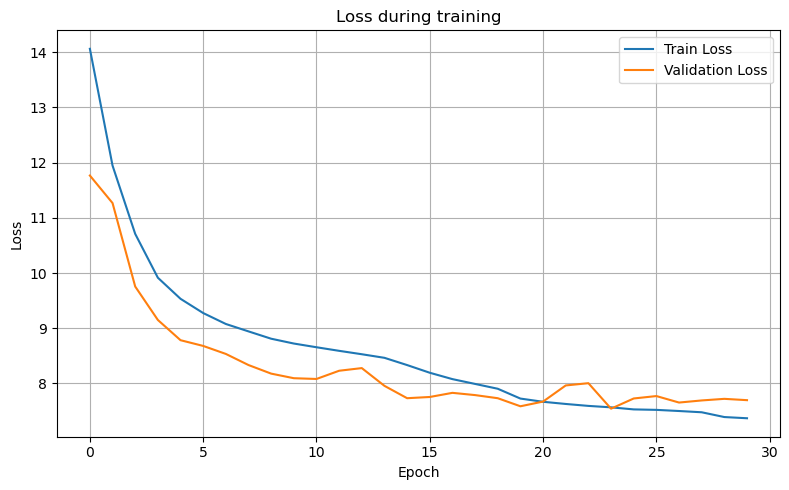

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_l, label='Train Loss')
plt.plot(val_loss_l, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()